# Notebook 3 – Basic QGT for a 1-Parameter State

**Level:** Beginner  
**Topics:** Fisher metric, Berry curvature, parameterized states, JAX Jacobians

> **Provenance:** This notebook is based on:
> - `examples/basic_qgt.py`

## 1. Setup: Rotating a Spinor by an Angle θ

We'll:

1. Initialize a Clifford engine and a random reference spinor ψ₀.
2. Define a **bivector generator** that rotates in the (0,1) plane.
3. Build a function `get_psi(theta)` that returns the rotated state.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.linalg as jla
import matplotlib.pyplot as plt

from light_theory_realm.engine import CliffordEngine
from light_theory_realm.qgt import CliffordQGT

engine = CliffordEngine(seed=42)
qgt = CliffordQGT(engine)

# Reference state
psi_0 = engine.random_spinor(jax.random.PRNGKey(0))

# Bivector generator S_01 = γ0 γ1 (up to conventions)
generator = engine.gammas[0] @ engine.gammas[1]

W1202 13:59:29.453888 1873135 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1202 13:59:29.473782 1873025 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [2]:
def get_psi(theta):
    """
    Rotate the initial state by angle theta (scalar float or length-1 array).
    """
    angle = jnp.asarray(theta)[0]
    U = jla.expm(-1j * angle * generator)
    return U @ psi_0

## 2. QGT at a Single θ

First, we'll reproduce the basic example: compute Fisher and Berry at a fixed angle, e.g. θ = 0.5.

In [3]:
theta_val = jnp.array([0.5])

# Jacobian of ψ(θ) with respect to θ
jacobian = jax.jacfwd(get_psi)(theta_val).reshape(4, 1)
psi_val = get_psi(theta_val)

fisher, berry = qgt.compute_full_qgt(psi_val, jacobian)

print(f"θ = {float(theta_val[0]):.3f}")
print(f"Fisher g_θθ  = {float(fisher[0, 0]):.6f}")
print(f"Berry Ω_θθ   = {float(berry[0, 0]):.6f}")

θ = 0.500
Fisher g_θθ  = 0.699765
Berry Ω_θθ   = 0.000000


## 3. Sweeping θ from 0 → π

Now we sample a whole curve:

- θ ∈ [0, π]
- For each θ, compute Fisher `g_θθ` and Berry `Ω_θθ`
- Plot both as functions of θ

In [4]:
def qgt_along_curve(theta):
    theta = jnp.asarray(theta)
    jac = jax.jacfwd(get_psi)(theta).reshape(4, 1)
    psi = get_psi(theta)
    fisher, berry = qgt.compute_full_qgt(psi, jac)
    return float(fisher[0, 0].real), float(berry[0, 0].real)

In [5]:
thetas = jnp.linspace(0.0, jnp.pi, 50)
fisher_vals = []
berry_vals = []

for th in thetas:
    g, omega = qgt_along_curve(jnp.array([th]))
    fisher_vals.append(g)
    berry_vals.append(omega)

thetas_np = jnp.array(thetas)
fisher_vals = jnp.array(fisher_vals)
berry_vals = jnp.array(berry_vals)

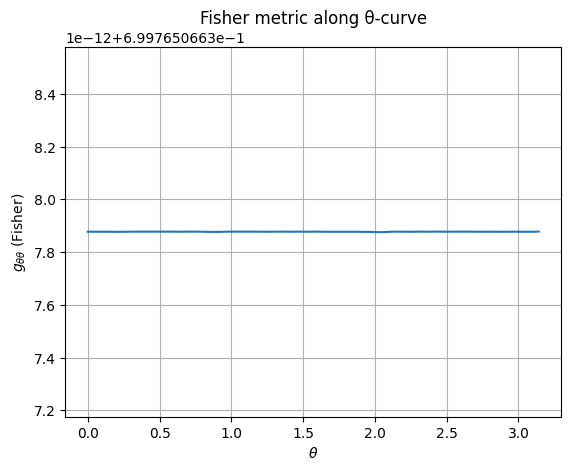

In [6]:
plt.figure()
plt.plot(thetas_np, fisher_vals)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$g_{\theta\theta}$ (Fisher)")
plt.title("Fisher metric along θ-curve")
plt.grid(True)
plt.show()

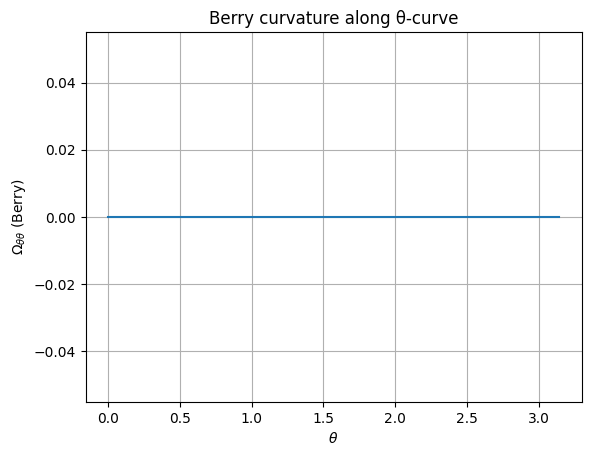

In [7]:
plt.figure()
plt.plot(thetas_np, berry_vals)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\Omega_{\theta\theta}$ (Berry)")
plt.title("Berry curvature along θ-curve")
plt.grid(True)
plt.show()

## 4. Interpretation

Some ways to read these plots:

- **Fisher metric g<sub>θθ</sub>**
  - Measures how *sensitive* the state is to changes in θ.
  - Where the curve is large, small changes in θ cause large changes in the state.

- **Berry curvature Ω<sub>θθ</sub>**
  - Measures how much **geometric phase / twist** builds up along the curve.
  - Non-zero values signal that the path in state space has topological structure.

Together, they form the **Quantum Geometric Tensor (QGT)** for this 1-parameter manifold.

---

### Next steps

- Re-run the notebook with different generators (e.g. rotate in (1,2) plane instead of (0,1)).
- Increase the number of θ samples to see finer structure.
- Move on to **Notebook 4 – Standard Model Mass Explorer** to connect this geometry back to fermion masses.